# Model Experimentation

This notebook focuses on predictive modeling for the Proactive Customer Retention project, building on the cleaned dataset from our EDA. Our goals are to (1) assess how well we can classify churn and (2) determine the best algorithm. We conduct a structured model “bake-off” to ensure a robust, well-justified final choice.

### Algorithms:

- Random Forest: Reliable ensemble baseline.

- XGBoost: High-performance gradient boosting, standard for tabular data.

- Deep Neural Network (DNN): Captures complex non-linear patterns with modern training practices.

### Evaluation Strategy
Due to class imbalance, we prioritize metrics beyond Accuracy:

- AUC-ROC: Overall separability.

- Recall (Churn class): Critical for retention impact.

- F1-Score (Churn class): Balanced effectiveness.

1. Imports and Setup

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier # New
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Evaluation
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score

In [24]:
# --- Define Client Brand Colors ---
NO_CHURN_COLOR = '#FF004F'
CHURN_COLOR = '#00FFBF'
# Add a third color for visualizations
NEUTRAL_COLOR = '#8C8C8C'

2. Data Loading and Preparation

In [25]:
df = pd.read_csv('Vodafone_Customer_Churn_Sample_Dataset.csv')
#df = pd.read_csv('C:\\Users\\esteb\\Documents\\GitHub\\customer-churn-and-personalisation\\data\\Vodafone_Customer_Churn_Sample_Dataset.csv')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
df.drop('customerID', axis=1, inplace=True)

X = df.drop('Churn', axis=1)
y = df['Churn']

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()


# === Preprocessing Pipeline ===
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


3. Model Training

In [26]:
# --- Model 1: Random Forest ---
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=150))])
print("Training Random Forest model...")
rf_pipeline.fit(X_train, y_train)
print("Done.\n")

# --- Model 2: XGBoost (Industry Standard) ---
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, 
                                                            eval_metric='logloss', scale_pos_weight=scale_pos_weight))])
print("Training XGBoost model...")
xgb_pipeline.fit(X_train, y_train)
print("Done.\n")

# --- Model 3: Neural Network ---
X_train_processed = rf_pipeline.named_steps['preprocessor'].transform(X_train)
X_test_processed = rf_pipeline.named_steps['preprocessor'].transform(X_test)
input_shape = X_train_processed.shape[1]

def nn_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'), BatchNormalization(), Dropout(0.4),
        Dense(32, activation='relu'), BatchNormalization(), Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

nn_model = nn_model(input_shape)
class_weight_0 = (1 / y_train.value_counts()[0]) * (len(y_train) / 2.0)
class_weight_1 = (1 / y_train.value_counts()[1]) * (len(y_train) / 2.0)
nn_class_weights = {0: class_weight_0, 1: class_weight_1}

early_stopping = EarlyStopping(monitor='val_auc', patience=25, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.2, patience=5, min_lr=0.00001, mode='max')

print("\nTraining Neural Network model...")
history = nn_model.fit(X_train_processed, y_train, epochs=200, batch_size=32, validation_split=0.2,
                                class_weight=nn_class_weights, callbacks=[early_stopping, reduce_lr], verbose=0)
print("Done. Model training stopped at epoch:", early_stopping.stopped_epoch)

Training Random Forest model...
Done.

Training XGBoost model...
Done.


Training Neural Network model...
Done. Model training stopped at epoch: 34


4. Model Evaluation

In [27]:
# Get predictions
rf_preds = rf_pipeline.predict(X_test)
xgb_preds = xgb_pipeline.predict(X_test)
nn_preds_proba = nn_model.predict(X_test_processed).flatten()
nn_preds = (nn_preds_proba > 0.5).astype(int)

# Get prediction probabilities for AUC
rf_preds_proba = rf_pipeline.predict_proba(X_test)[:, 1]
xgb_preds_proba = xgb_pipeline.predict_proba(X_test)[:, 1]

# Store results in a dictionary
results = {
    'Random Forest': {
        'AUC': roc_auc_score(y_test, rf_preds_proba),
        'F1 (Churn)': f1_score(y_test, rf_preds, pos_label=1),
        'Recall (Churn)': recall_score(y_test, rf_preds, pos_label=1),
        'Precision (Churn)': precision_score(y_test, rf_preds, pos_label=1)
    },
    'XGBoost': {
        'AUC': roc_auc_score(y_test, xgb_preds_proba),
        'F1 (Churn)': f1_score(y_test, xgb_preds, pos_label=1),
        'Recall (Churn)': recall_score(y_test, xgb_preds, pos_label=1),
        'Precision (Churn)': precision_score(y_test, xgb_preds, pos_label=1)
    },
    'Neural Network': {
        'AUC': roc_auc_score(y_test, nn_preds_proba),
        'F1 (Churn)': f1_score(y_test, nn_preds, pos_label=1),
        'Recall (Churn)': recall_score(y_test, nn_preds, pos_label=1),
        'Precision (Churn)': precision_score(y_test, nn_preds, pos_label=1)
    }
}

# Print the results
print("\n" + "="*60)
print("              Final Model Performance")
print("="*60)
for model_name, metrics in results.items():
    print(f"\n--- {model_name} ---")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
print("="*60)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

              Final Model Performance

--- Random Forest ---
AUC: 0.8213
F1 (Churn): 0.5465
Recall (Churn): 0.4866
Precision (Churn): 0.6233

--- XGBoost ---
AUC: 0.8187
F1 (Churn): 0.5877
Recall (Churn): 0.6631
Precision (Churn): 0.5277

--- Neural Network ---
AUC: 0.8386
F1 (Churn): 0.6157
Recall (Churn): 0.7968
Precision (Churn): 0.5017


5. Results Visualisation and Saving


Chart saved successfully as 'model_performance_comparison.png'


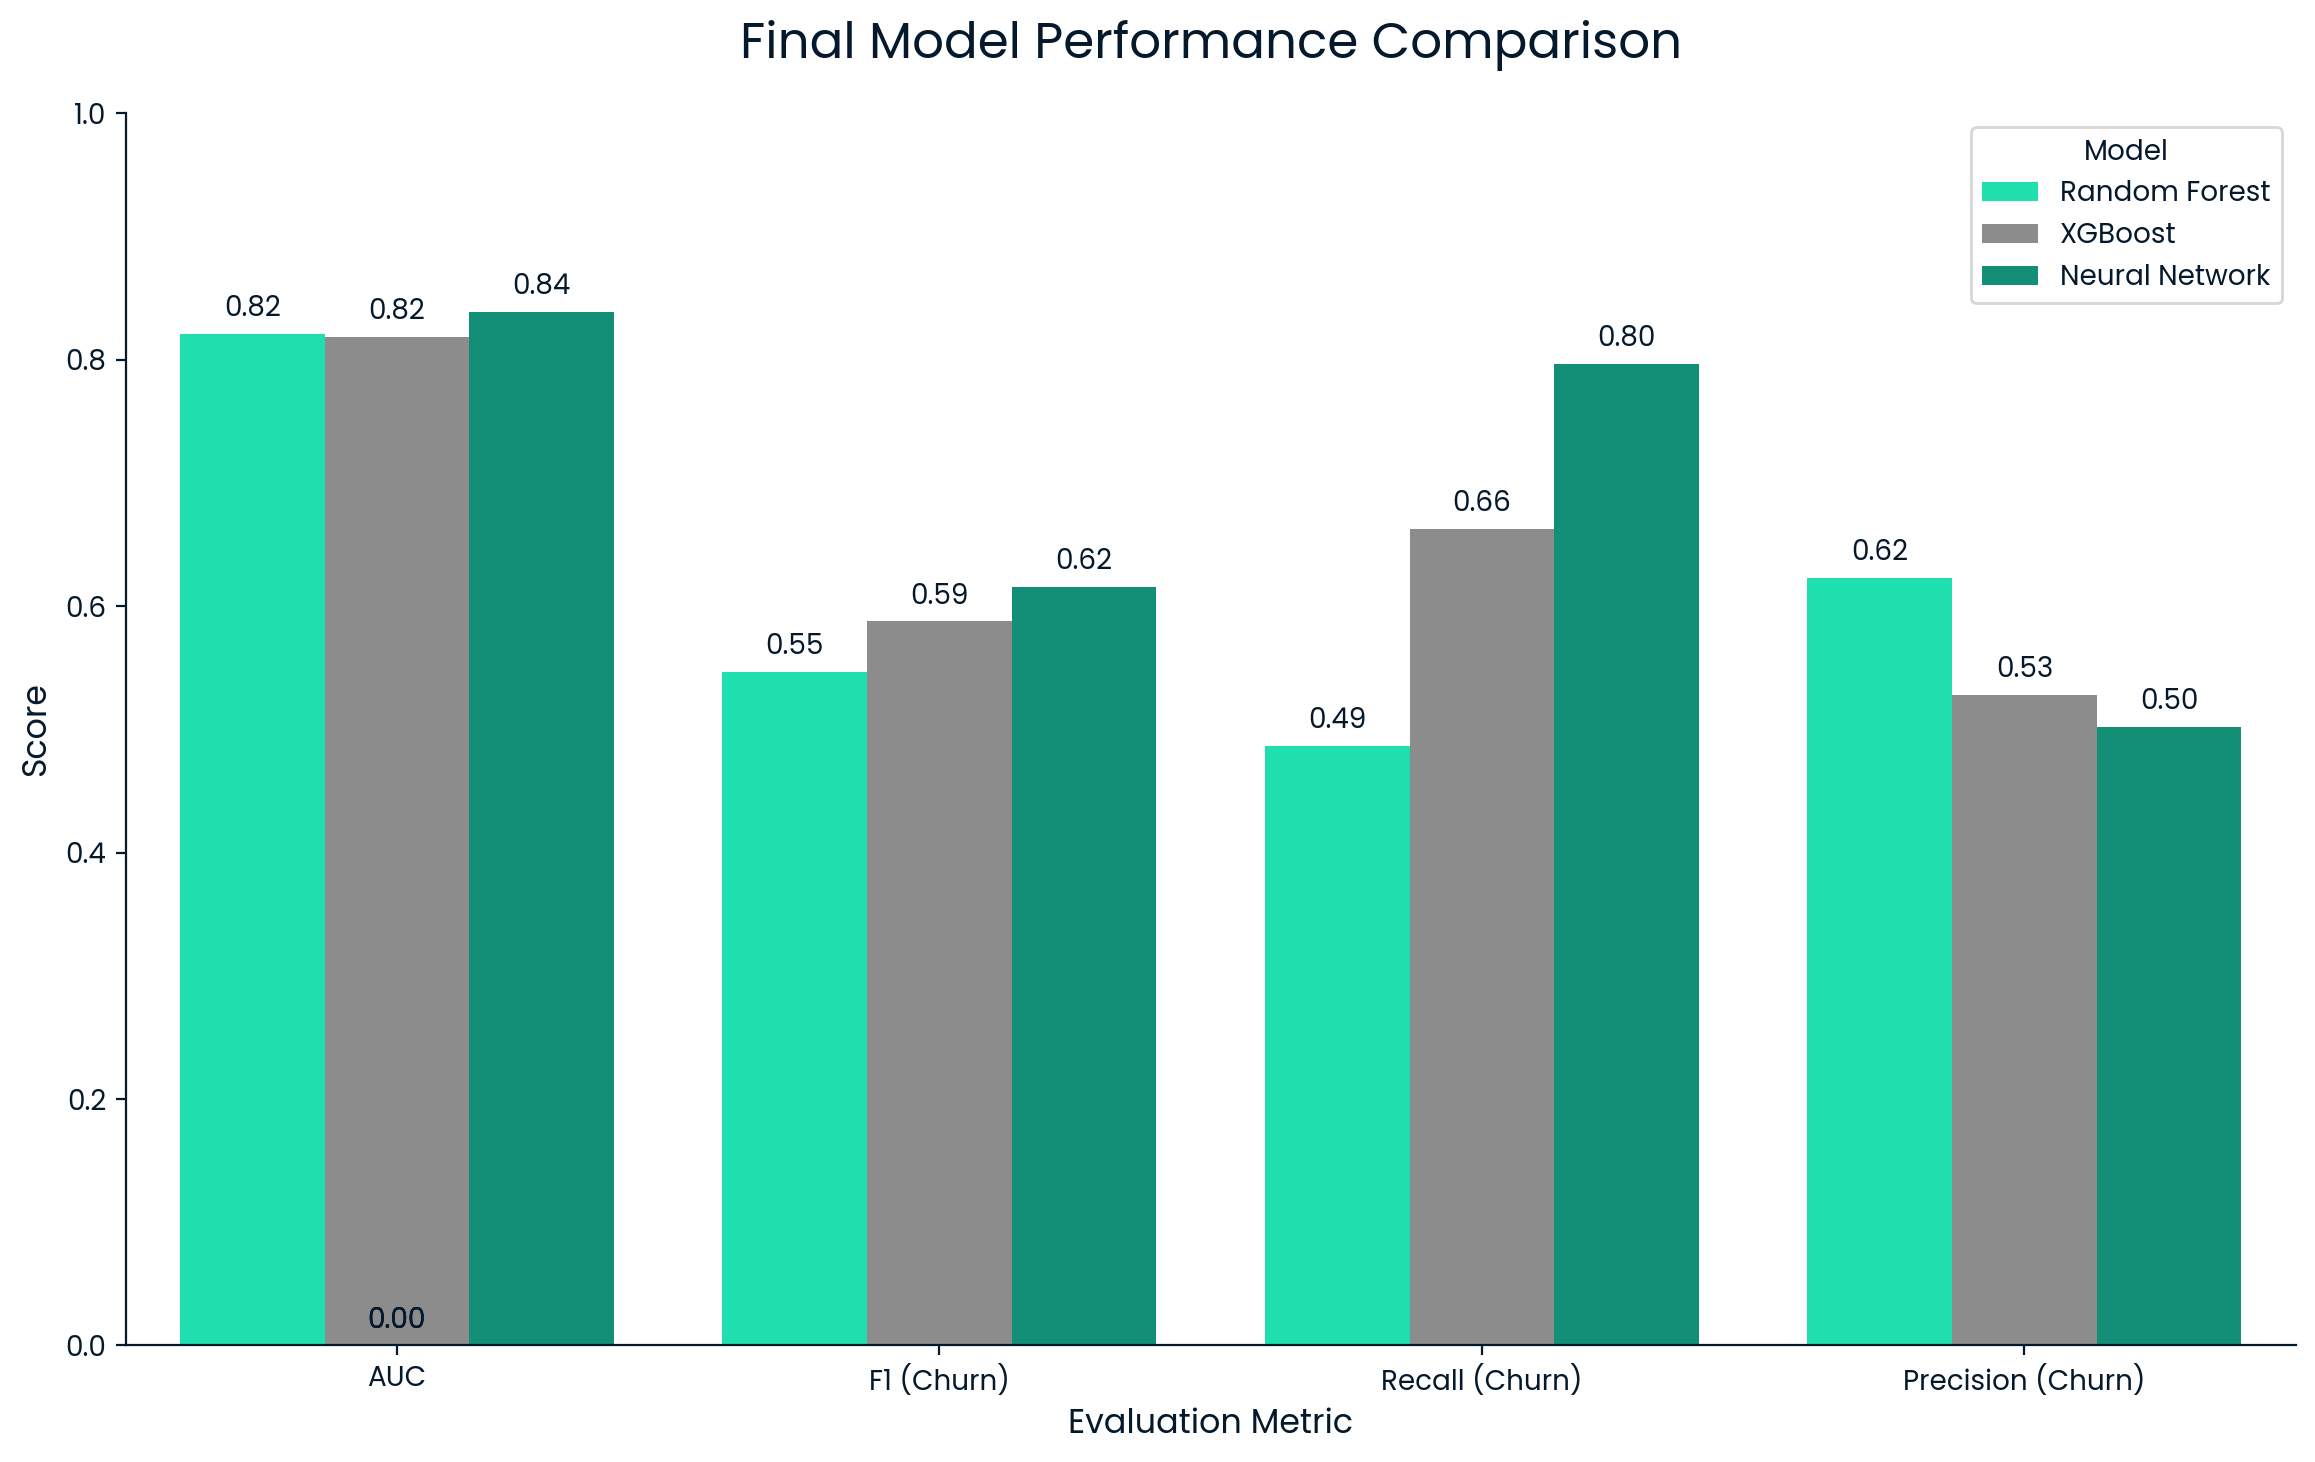

In [28]:
# Convert results dictionary to a DataFrame for easier plotting
results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Model'})
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create the plot
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=results_melted, x='Metric', y='Score', hue='Model', 
                 palette=[CHURN_COLOR, NEUTRAL_COLOR, '#00A383', '#B2DFD6']) # A palette derived from our brand colors

# Add annotations
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# Customize and save
plt.title('Final Model Performance Comparison', fontsize=18, pad=20)
plt.xlabel('Evaluation Metric', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1.0)
plt.legend(title='Model', fontsize=10)
sns.despine()

# Save the figure to a PNG file
output_filename = 'model_performance_comparison.png'
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
print(f"\nChart saved successfully as '{output_filename}'")

plt.show()